## Stock Return Prediction

In this case study, we will use various supervised learning-based models to predict the
stock price of Microsoft using correlated assets and its own historical data.

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the
Microsoft stock is the predicted variable. We need to understand what affects Microsoft stock price and hence incorporate as much information into the model. 

For this case study, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones and VIX


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
import os
import sys


root_dir = os.path.abspath('../..')
sys.path.append(root_dir)

from functions import (
    ParamsKfold, ResultKfold, 
    calc_best_features, run_kfold_analysis, show_corr_matrix, show_scatter_matrix, 
    show_seasonal_decomposition, show_boxplot_kfold, show_bar_kfold
)
from case_study_1 import ArimaParams, LstmParams, create_lstm_model, run_grid_search_arima, load_data, clean_data


2022-10-06 14:38:10.896148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-06 14:38:10.896193: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Core libraries

from dataclasses import dataclass, field
from datetime import date
from typing import List

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from matplotlib import pyplot
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor

# Libraries for Statistical Models
import statsmodels.api as sm

# Libraries for Saving the Model
from pickle import dump, load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression

# Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [3]:
# Disable the warnings

import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader. 

In [4]:
start = date(2010, 1, 1)
end = date(2020, 12, 31)
params = {
    'stk': {'tickers': ['MSFT', 'IBM', 'GOOGL'], 'data_source': 'yahoo'},
    'ccy': {'tickers': ['DEXJPUS', 'DEXUSUK'], 'data_source': 'fred'},
    'idx': {'tickers': ['SP500', 'DJIA', 'VIXCLS'], 'data_source': 'fred'},
}

data = load_data(start, end, params)

Next, we choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [5]:
period = 5

We now define our X and Y series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns
    b. IBM 5 Business DayReturns    
    c. USD/JPY 5 Business DayReturns    
    d. GBP/USD 5 Business DayReturns    
    e. S&P 500 5 Business DayReturns    
    f. Dow Jones 5 Business DayReturns    
    g. MSFT 5 Business Day Returns    
    h. MSFT 15 Business Day Returns    
    i. MSFT 30 Business Day Returns    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [6]:
X, Y = clean_data(data, period)
dataset = pd.concat([X, Y], axis=1)


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [7]:
dataset.describe()

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,0.003443,-0.000849,0.000597,-0.000843,0.001516,0.001312,0.004594,0.004774,0.014647,0.030916,0.062045,0.005341
std,0.034817,0.033530,0.012358,0.013500,0.022760,0.024011,0.165063,0.033661,0.049597,0.067181,0.085531,0.034128
min,-0.159180,-0.168251,-0.041651,-0.105527,-0.162279,-0.189978,-0.559093,-0.155315,-0.165125,-0.287663,-0.147896,-0.155315
25%,-0.013460,-0.015370,-0.005990,-0.008075,-0.004767,-0.006858,-0.083733,-0.009374,-0.009084,-0.003352,0.008831,-0.010084
50%,0.006529,0.000377,0.001022,-0.000929,0.003404,0.003332,-0.006709,0.006614,0.015501,0.033299,0.071666,0.006850
75%,0.022971,0.014924,0.007218,0.006711,0.012915,0.012153,0.078685,0.022964,0.045135,0.071533,0.118059,0.024206
max,0.174206,0.130388,0.058566,0.051208,0.097697,0.120840,0.960131,0.132077,0.186499,0.284662,0.283020,0.132077


In [8]:
dataset.head()

,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT,MSFT_pred
2012-10-16,0.000819,0.014368,0.008781,0.007105,0.009281,0.005791,-0.072840,0.007146,-0.030063,-0.030063,0.013749,-0.050062
2012-10-23,-0.090374,-0.098277,0.010964,-0.010552,-0.029158,-0.033713,0.212841,-0.050062,-0.055810,-0.093201,-0.048533,0.051079
2012-11-01,0.010585,0.030384,0.001249,0.001426,0.010294,0.009792,-0.082207,0.051079,0.008163,-0.054709,-0.007858,-0.024346
2012-11-13,-0.033820,-0.030849,-0.010770,-0.006276,-0.038436,-0.037656,-0.054352,-0.089172,-0.047456,-0.085817,-0.119517,-0.014127
2012-11-21,0.020207,0.025440,0.026576,0.005474,0.025881,0.020934,-0.157411,0.004090,-0.049140,-0.091670,-0.117525,0.000000


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

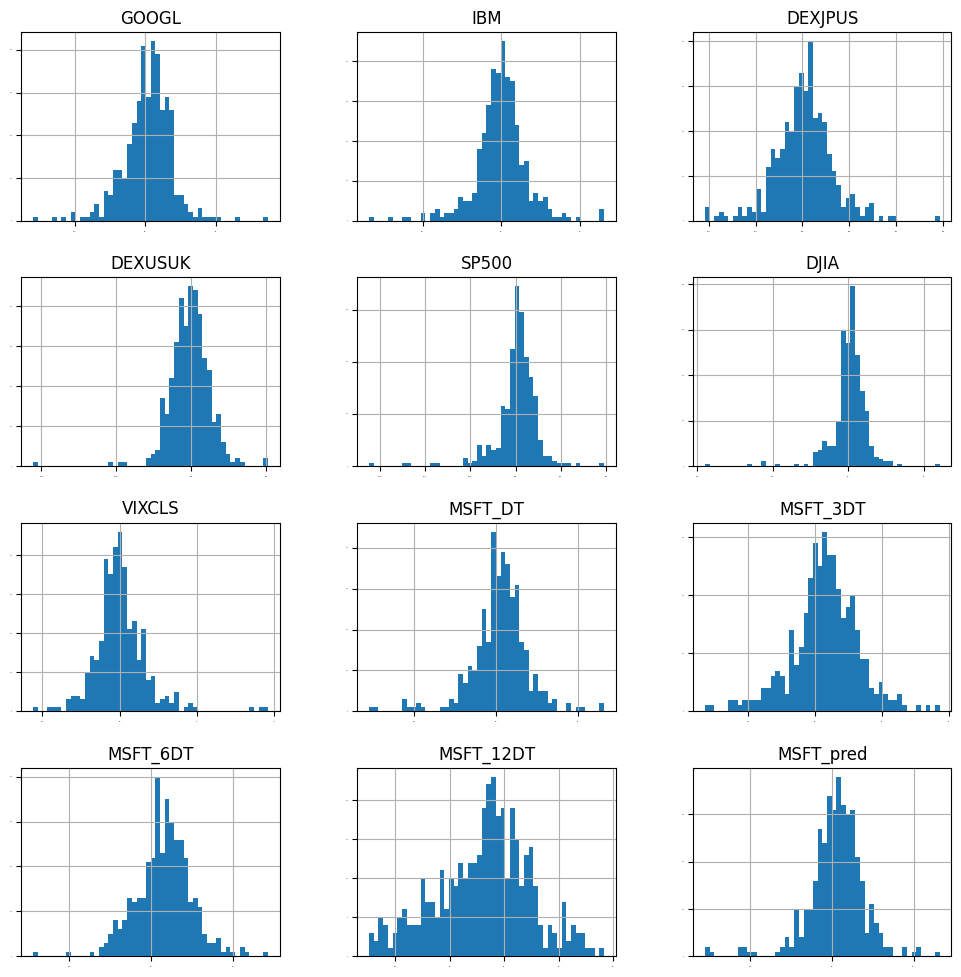

In [9]:
dataset.hist(
    bins=50, 
    sharex=False, 
    sharey=False, 
    xlabelsize=1, 
    ylabelsize=1, 
    figsize=(12, 12)
)
pyplot.show()


The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

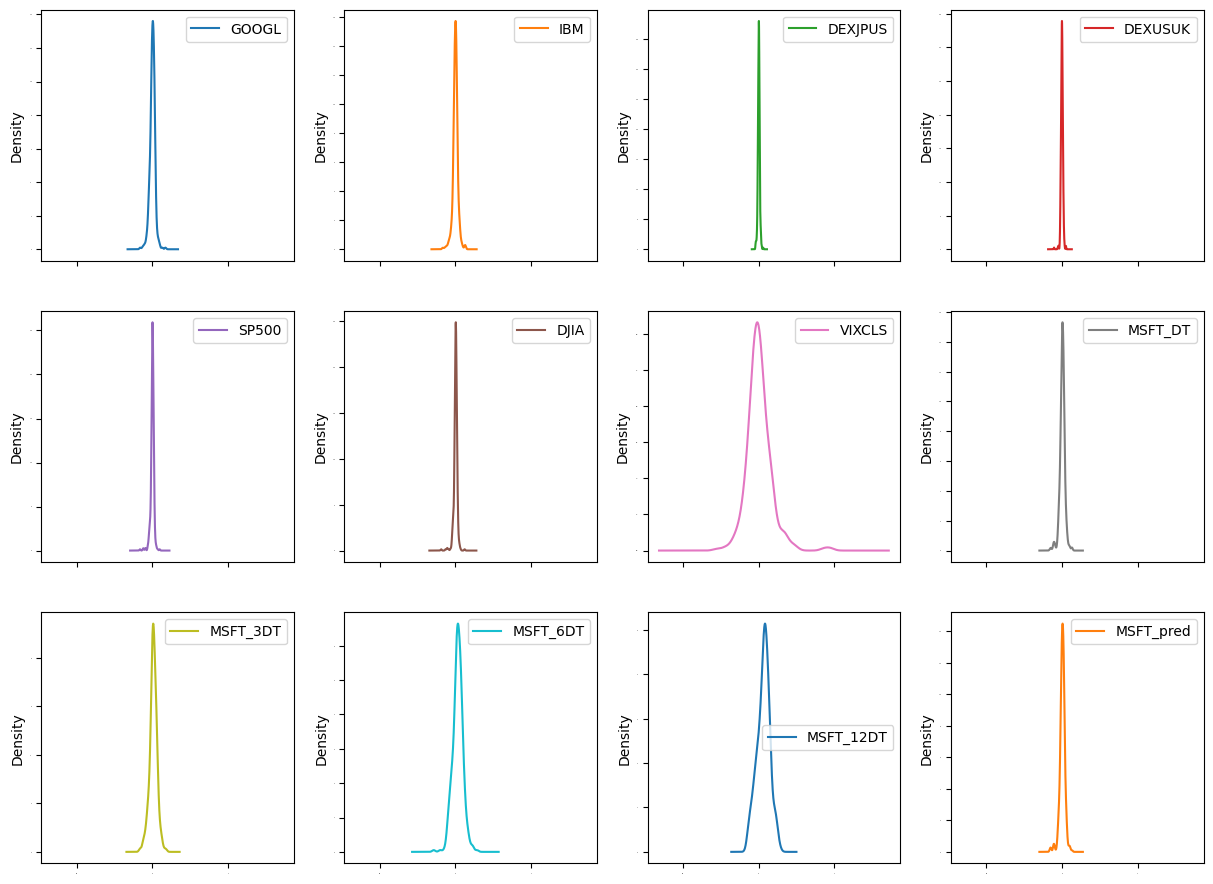

In [10]:
dataset.plot(
    kind='density', 
    subplots=True, 
    layout=(4, 4), 
    sharex=True, 
    legend=True, 
    fontsize=1, 
    figsize=(15, 15)
)
pyplot.show()


We can see that the vix has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

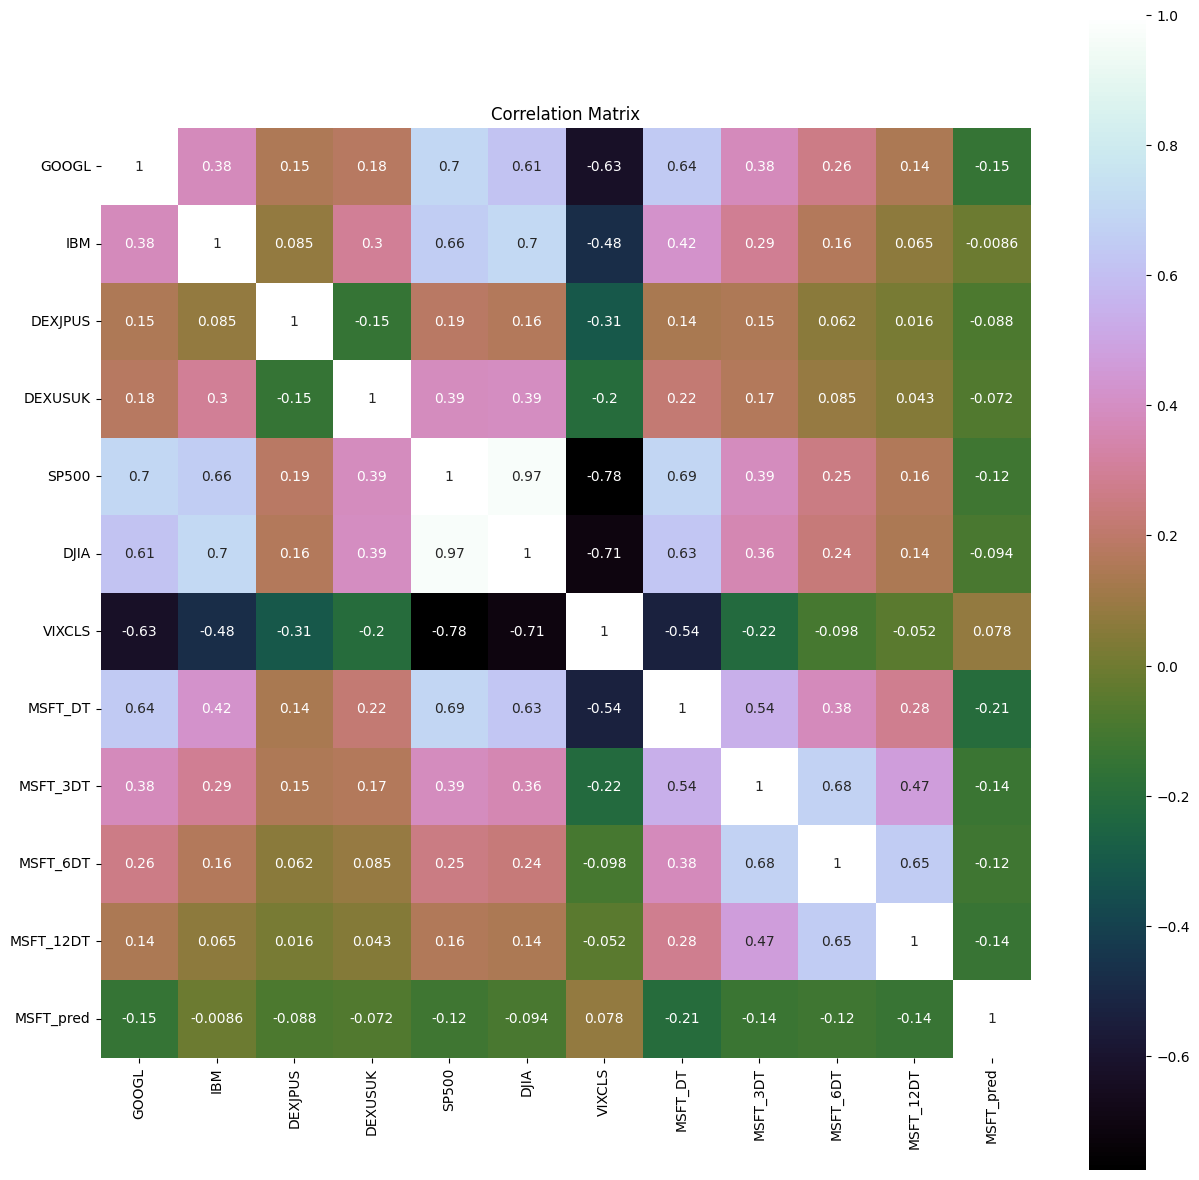

In [11]:
show_corr_matrix(dataset)


Looking at the correlation plot above, we see some correlation of the predicted variable with the lagged 5 days, 15days, 30 days and 60 days return of MSFT. 

<Figure size 1500x1500 with 0 Axes>

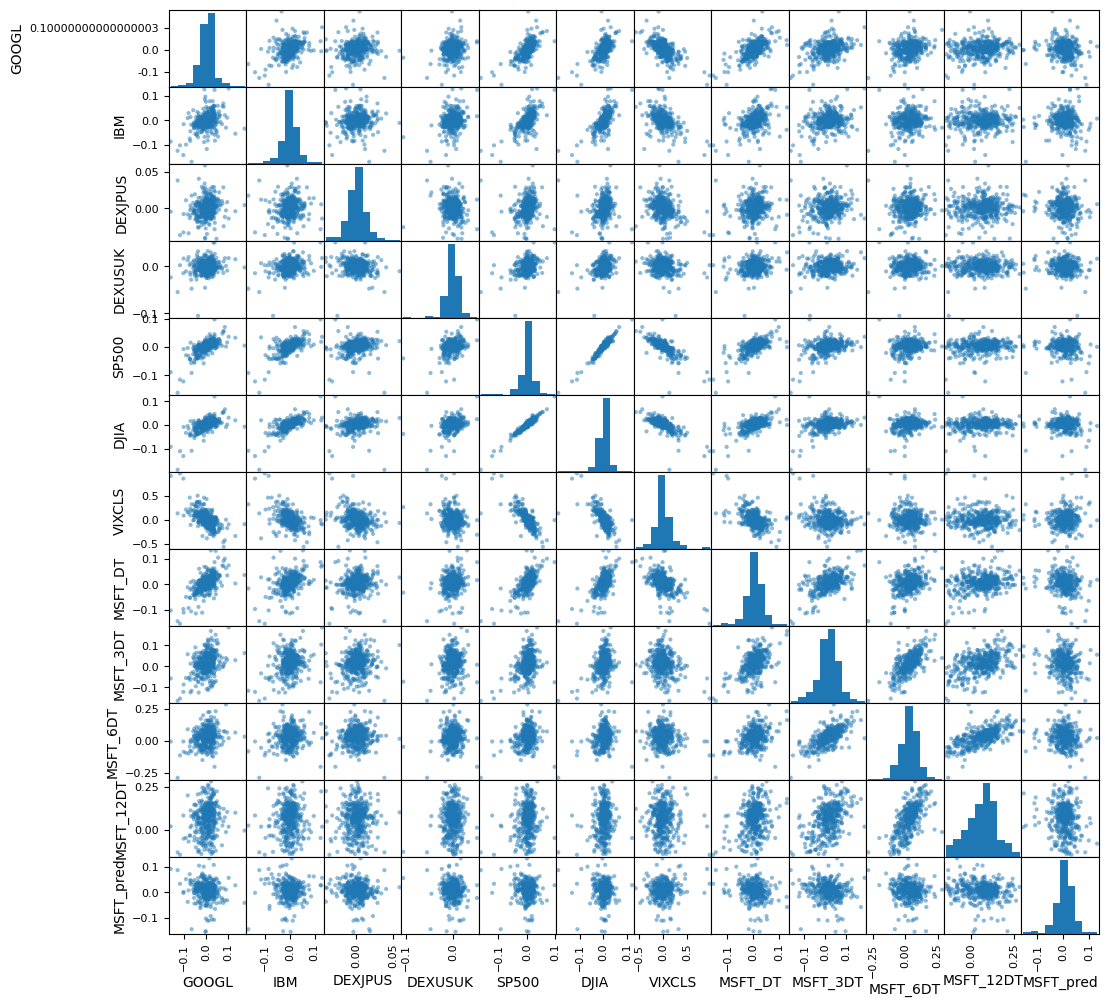

In [12]:
show_scatter_matrix(dataset)

Looking at the scatter plot above, we see some linear relationship of the predicted
variable the lagged 15 days, 30 days and 60 days return of MSFT.

<a id='2.3'></a>
## 3.3. Time Series Analysis 

Next, we look at the seasonal decomposition of our time series

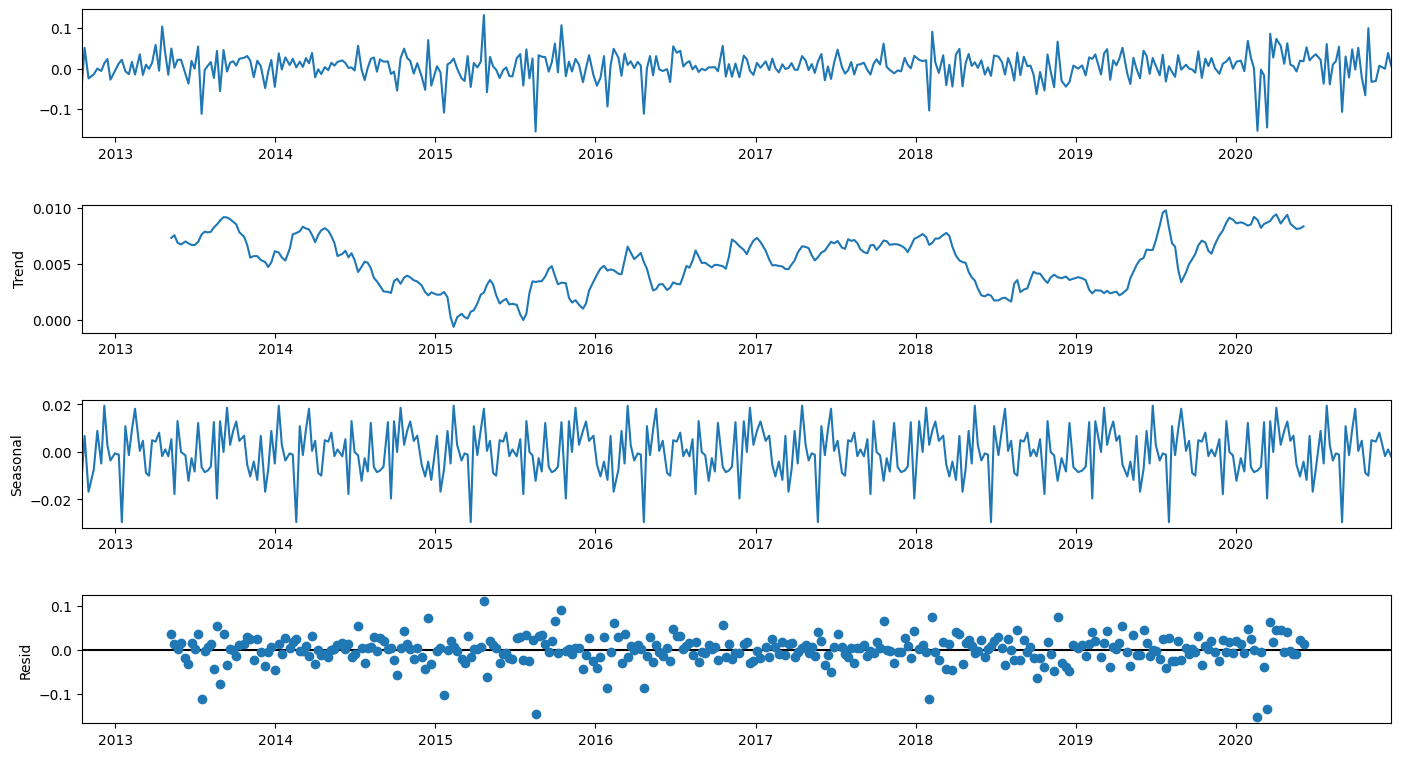

In [37]:
show_seasonal_decomposition(Y)


<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance. 

In [14]:
calc_best_features(X, Y)

----------------------------------------------------------------
               Score
Specs               
MSFT_DT    17.047516
GOOGL       8.632578
MSFT_12DT   8.091538
MSFT_3DT    7.422535
MSFT_6DT    5.760487
SP500       5.601036
DJIA        3.448536
DEXJPUS     3.043569
VIXCLS      2.402966
DEXUSUK     2.001848


<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [15]:
# In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
# This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.

validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))
models = [
	# Linear models
	('LR', LinearRegression()),
	('LASSO', Lasso()),
	('EN', ElasticNet()),
	('KNN', KNeighborsRegressor()),
	('CART', DecisionTreeRegressor()),
	('SVR', SVR()),

	# Neural network model
	('MLP', MLPRegressor()),

	# Ensamble models
	('ABR', AdaBoostRegressor()),
	('GBR', GradientBoostingRegressor()),
	('RFR', RandomForestRegressor()),
	('ETR', ExtraTreesRegressor()),
]
X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(X)]

params = ParamsKfold(
    models=models,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=10,
    scoring='neg_mean_squared_error',
)


<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [16]:
kfold_results = run_kfold_analysis(params)


LR: 0.001025 (0.000517) 0.000950 0.001763
LASSO: 0.001022 (0.000567) 0.001021 0.001727
EN: 0.001022 (0.000567) 0.001021 0.001727
KNN: 0.001217 (0.000545) 0.000766 0.002002
CART: 0.002550 (0.000747) 0.000000 0.003496
SVR: 0.002033 (0.000525) 0.001947 0.002496
MLP: 0.001295 (0.000713) 0.001460 0.002404
ABR: 0.001130 (0.000547) 0.000595 0.001832
GBR: 0.001245 (0.000606) 0.000204 0.001867
RFR: 0.001157 (0.000597) 0.000156 0.001862
ETR: 0.001159 (0.000564) 0.000000 0.001884


#### K Fold results

We being by looking at the K Fold results

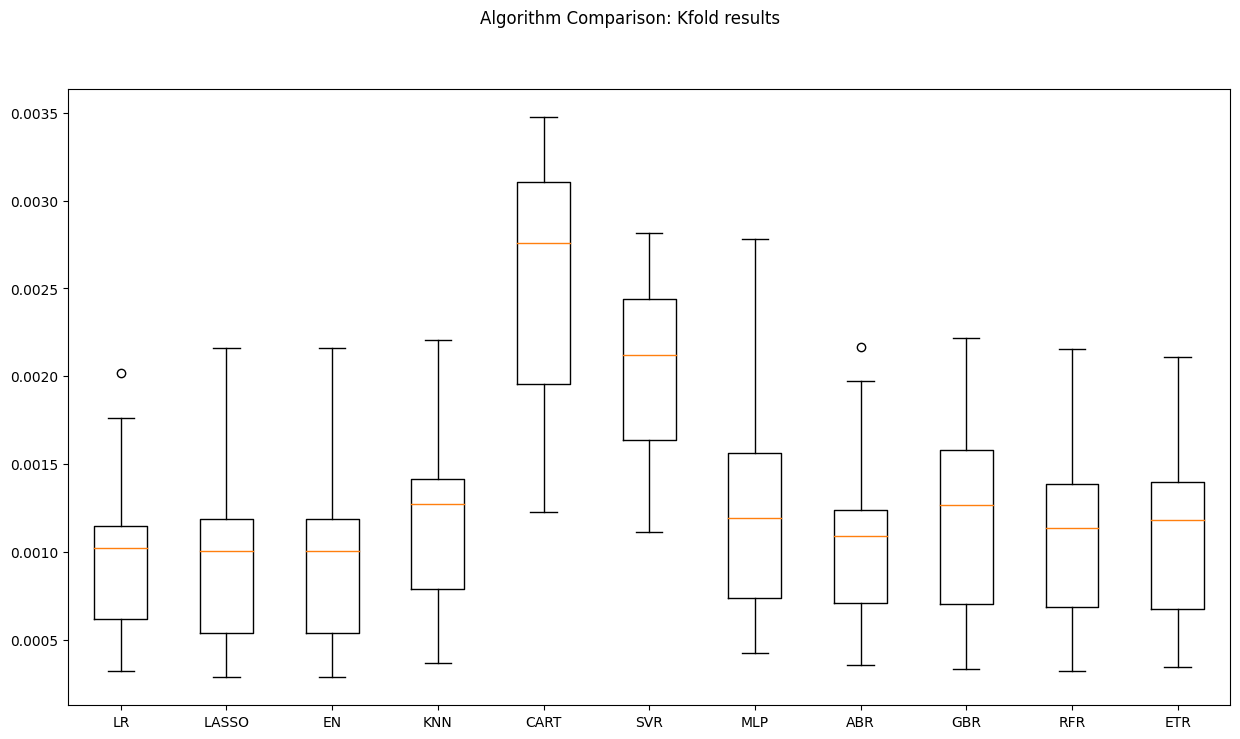

In [17]:
show_boxplot_kfold(kfold_results)


We see the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seem to do a good job.

#### Training and Test error

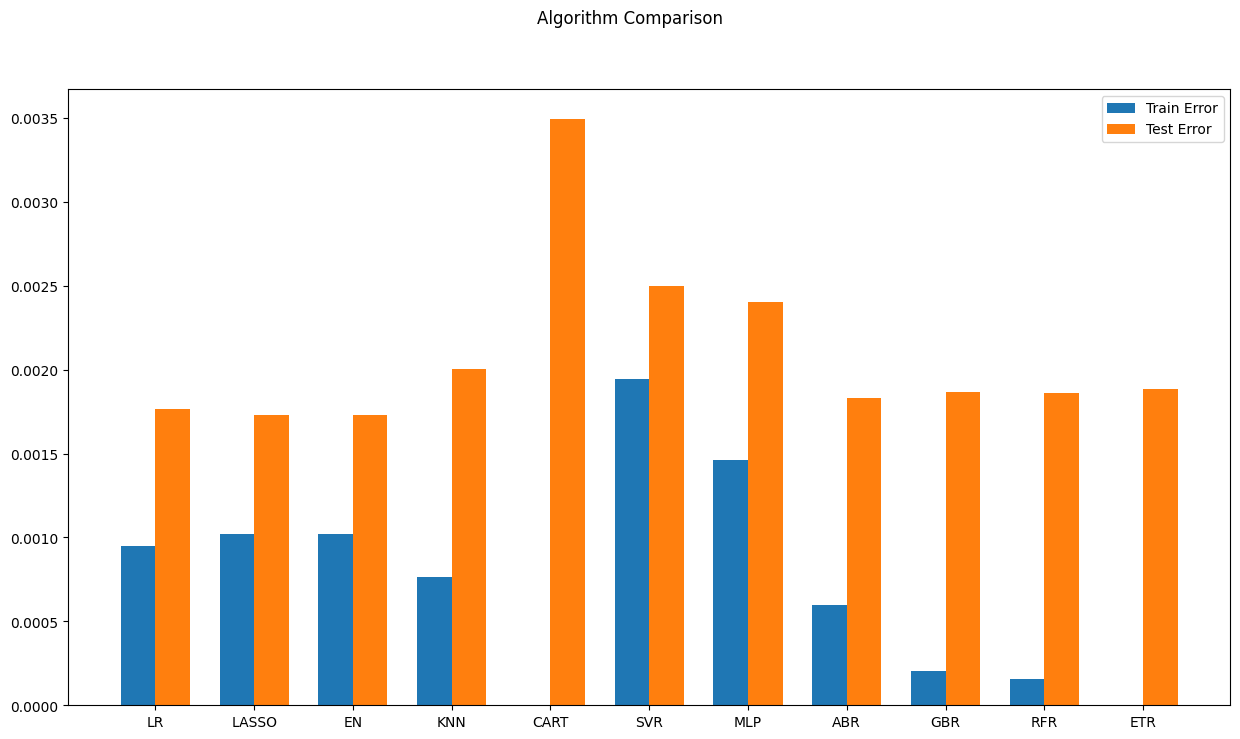

In [18]:
show_bar_kfold(kfold_results)


Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided. Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance. We also see that the
artificial neural network (shown as MLP is the chart) algorithm shows higher errors
both in training set and test set, which is perhaps due to the linear relationship of the
variables not captured accurately by ANN or improper hyperparameters or insufficient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA and LSTM

Let us first prepare the dataset for ARIMA models,
by having only the correlated varriables as exogenous variables.

### Time Series Model - ARIMA Model

In [19]:
columns_ARIMA = ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']
X_train_ARIMA = X_train.loc[:, columns_ARIMA]
X_test_ARIMA = X_test.loc[:, columns_ARIMA]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)


In [20]:
model = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[1, 0, 0])
model_fitted = model.fit()
Y_test_predict = model_fitted.predict(start=tr_len - 1, end=to_len - 1, exog=X_test_ARIMA)[1:]


In [21]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fitted.fittedvalues)
error_Test_ARIMA = mean_squared_error(Y_test, Y_test_predict)


In [22]:
error_Training_ARIMA

0.0009631250400830053

In [23]:
error_Test_ARIMA

0.001788977444886179

###  LSTM Model

In [24]:
seq_len = 2 # Length of the seq for the LSTM
X_train_LSTM = np.zeros((X_train.shape[0] + 1 - seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
Y_train_LSTM = np.array(Y_train)[seq_len - 1:]
Y_test_LSTM = np.array(Y_test)
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0] + i + 1 - seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0] + i - 1 : X.shape[0] + i + 1 - seq_len, :]


In [25]:
# LSTM Network

params_lstm = LstmParams(X_train=X_train_LSTM, neurons=12, learn_rate=0.01, momentum=0)
LSTMModel = create_lstm_model(params_lstm)
LSTMModel_fit = LSTMModel.fit(
    X_train_LSTM, 
    Y_train_LSTM, 
    validation_data=(X_test_LSTM, Y_test_LSTM),
    epochs=330, 
    batch_size=72, 
    verbose=0, 
    shuffle=False
)


2022-10-06 14:38:45.860802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-06 14:38:45.860940: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-06 14:38:45.860967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-8U9O950M): /proc/driver/nvidia/version does not exist
2022-10-06 14:38:45.861292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


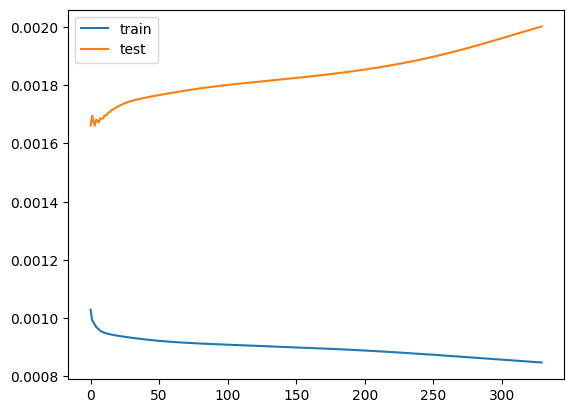

In [26]:
# Visual plot to check if the error is reducing

pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [27]:
Y_train_predict = LSTMModel.predict(X_train_LSTM)
Y_test_predict = LSTMModel.predict(X_test_LSTM)

error_Training_LSTM = mean_squared_error(Y_train_LSTM, Y_train_predict)
error_Test_LSTM = mean_squared_error(Y_test, Y_test_predict)


3/3 [==============================] - 0s 3ms/step


In [28]:
error_Training_LSTM

0.0008419274518432487

In [29]:
error_Test_LSTM

0.002002058631153475

#### Append to previous results

In [30]:
kfold_results.test_results.append(error_Test_ARIMA)
kfold_results.test_results.append(error_Test_LSTM)

kfold_results.train_results.append(error_Training_ARIMA)
kfold_results.train_results.append(error_Training_LSTM)

kfold_results.names.append("ARIMA")
kfold_results.names.append("LSTM")


## Overall Comparison of all the algorithms ( including Time Series Algorithms)

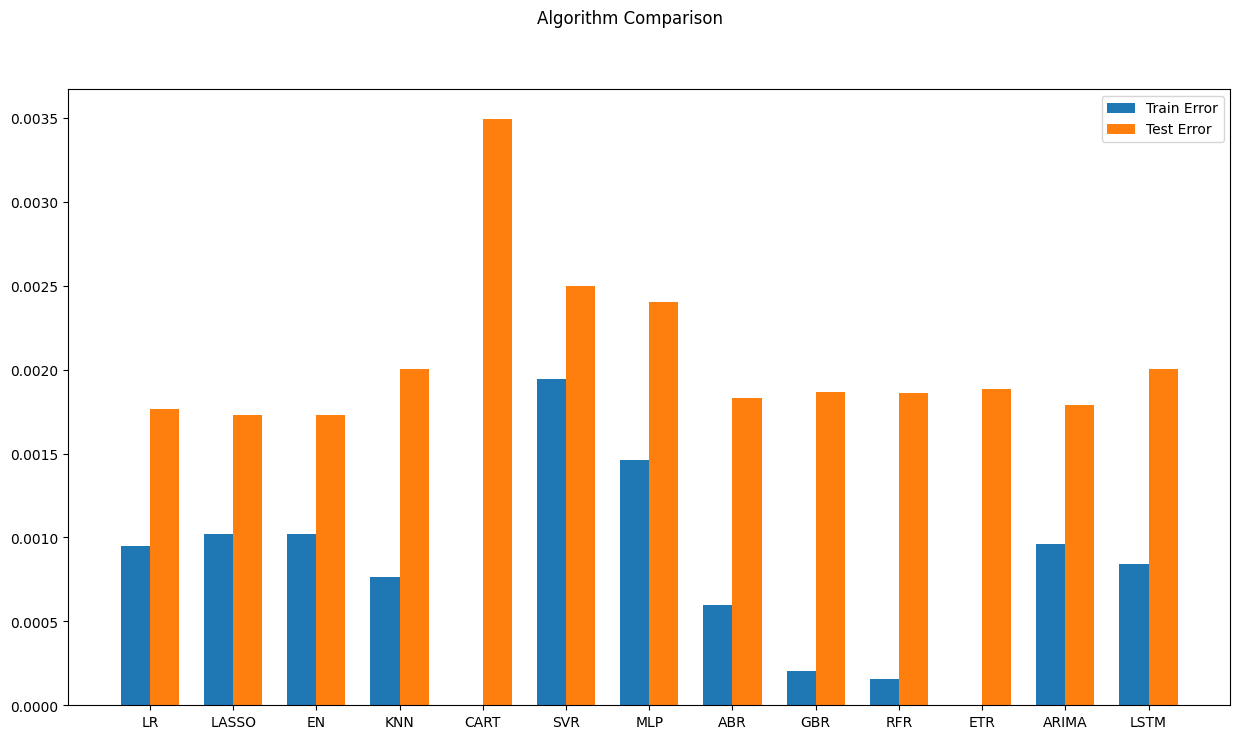

In [31]:
show_bar_kfold(kfold_results)


Looking at the chart above, we find time series based ARIMA model comparable to
the linear supervised-regression models such as Linear Regression (LR), Lasso Regression (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear
relationship as discussed before. The LSTM model performs decently, however,
ARIMA model outperforms the LSTM model in the test set. Hence, we select the
ARIMA model for the model tuning.

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p,d and q in the ARIMA model's order.  

In [32]:
# Grid Search for ARIMA Model. Change p, d and q and check for the best result

# Evaluate parameters
arima_params = ArimaParams(X_train=X_train_ARIMA, Y_train=Y_train)
best_cfg = run_grid_search_arima(arima_params)

ARIMA (0, 0, 0) MSE=0.0009874
ARIMA (0, 0, 1) MSE=0.0009658
ARIMA (0, 1, 0) MSE=0.0020027
ARIMA (0, 1, 1) MSE=0.0010228
ARIMA (1, 0, 0) MSE=0.0009631
ARIMA (1, 0, 1) MSE=0.0009630
ARIMA (1, 1, 0) MSE=0.0014844
ARIMA (1, 1, 1) MSE=0.0010233
ARIMA (2, 0, 0) MSE=0.0009629
ARIMA (2, 0, 1) MSE=0.0009627
ARIMA (2, 1, 0) MSE=0.0013053
ARIMA (2, 1, 1) MSE=0.0010422
Best ARIMA (2, 0, 1) MSE=0.0009627


<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [33]:
# Prepare model

model = ARIMA(exog=X_train_ARIMA, endog=Y_train, order=best_cfg)
model_fitted = model.fit()
Y_test_predict = model_fitted.predict(exog=X_test_ARIMA, start=tr_len-1, end=to_len-1)[1:]


In [34]:
mean_squared_error(Y_test, Y_test_predict)

0.001779950021950803

After tuning the model and picking the best ARIMA model, we select this model and can it can be used for the modeling purpose. 

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [35]:
# Save the model to disk

filename = 'finalized_model.sav'
with open(filename, 'wb') as fh:
    dump(model_fitted, fh)


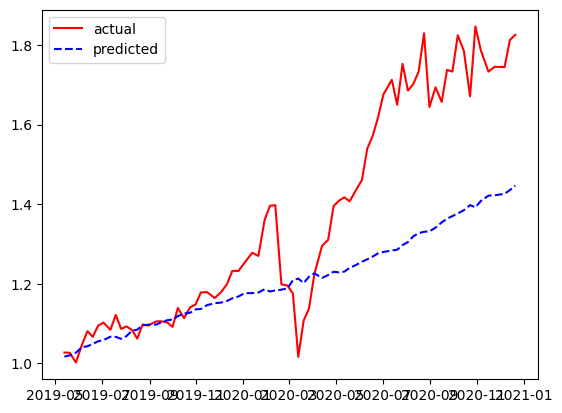

In [36]:
# Plotting the actual data versus predicted data

Y_test_predict.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r', label='actual',)

# Plotting t, a separately

pyplot.plot(np.exp(Y_test_predict).cumprod(), 'b--', label='predicted')
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (8, 5)
pyplot.show()


### Summary

We can conclude that simple models - linear regression, regularized regression (i.e.
Lasso and elastic net) - along with the time series model such as ARIMA are promis‐
ing modelling approaches for asset price prediction problem. These models can
enable financial practitioners to model time dependencies with a very flexible
approach. The overall approach presented in this case study may help us encounter
overfitting and underfitting which are some of the key challenges in the prediction
problem in finance.
We should also note that we can use better set of indicators, such as P/E ratio, trading
volume, technical indicators or news data, which might lead to better results. We will
demonstrate this in some of the case studies in the book.
Overall, we created a supervised-regression and time series modelling framework
which allows us to perform asset class prediction using historical data to generate
results and analyze risk and profitability before risking any actual capital.